# Process CD8 Data for svgs

23JAN24

In [1]:
figdir = "/home/ckmah/d/bento-manuscript/figures/breast_cancer_supp"

In [2]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import bento as bt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

# Load the data

In [3]:
# data directory
adata = bt.io.read_h5ad("cd8_crop_flux.h5ad")
adata

AnnData object with n_obs × n_vars = 103 × 541
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden_res1.0', 'cell_type', 'cell_area', 'cell_aspect_ratio', 'cell_density', 'nucleus_area', 'nucleus_aspect_ratio', 'nucleus_density', 'cell_radius', 'nucleus_radius'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_raster', 'cell_type_colors', 'dendrogram_cell_type', 'flux', 'flux_counts', 'flux_embed', 'flux_genes', 'flux_n_components', 'flux_sv', 'flux_variance_ratio', 'leiden', 'leiden_res1.0_colors', 'log1p', 'neighbors', 'pca', 'point_sets', 'points', 'rank_genes_groups', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts

In [4]:
valid_genes = ~(
    adata.var_names.str.startswith("BLANK")
    | adata.var_names.str.startswith("NegControl")
)
adata = adata[:, valid_genes]
bt.sync(adata)

In [5]:
flux_params = dict(res=1, alpha=True, dx=0.2125)

# RNAflux

In [6]:
def rnaFlux(adata, res=1):
    if "cell_raster" in adata.uns_keys():
        del adata.uns["cell_raster"]
    if "cell_raster" in adata.obs_keys():
        del adata.obs["cell_raster"]
    if "cell_raster" in adata.uns["point_sets"]:
        del adata.uns["point_sets"]["cell_raster"]
    # mean_radius = adata.obs["cell_radius"].mean()
    bt.tl.flux(adata, res=res, n_components=10, train_size=1)

In [7]:
rnaFlux(adata)

  0%|          | 0/103 [00:00<?, ?it/s]

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/CD8_rnaflux.svg


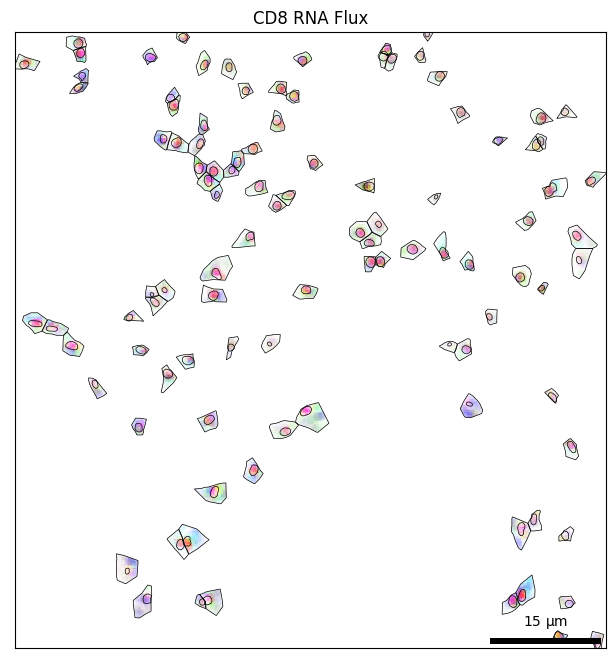

In [8]:
plt.figure(figsize=(8, 8))
bt.pl.flux(
    adata,
    **flux_params,
    title="CD8 RNA Flux",
    fname=f"{figdir}/CD8_rnaflux.svg",
)

# Fluxmap

In [9]:
res = 1
bt.tl.fluxmap(adata, res=res, n_clusters=3, min_points=0)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/CD8_fluxmap.svg


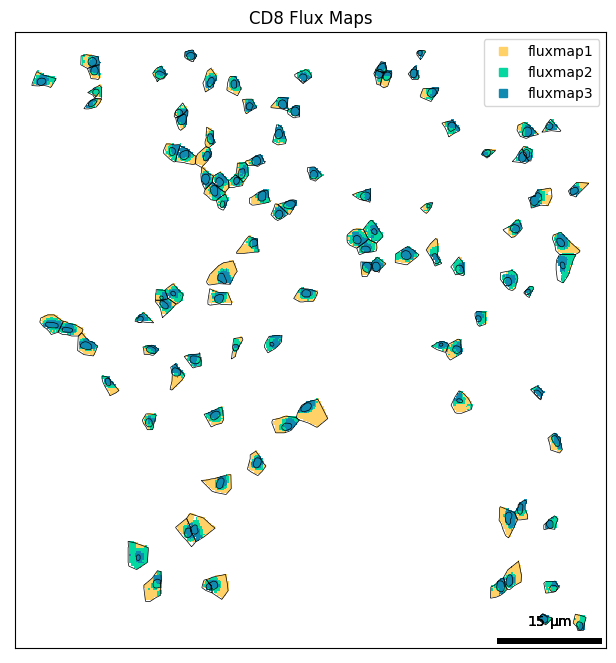

In [10]:
plt.figure(figsize=(8, 8))
bt.pl.fluxmap(
    adata,
    title="CD8 Flux Maps",
    palette=sns.color_palette(bt.colors.bento6, n_colors=3),
    lw=0,
    dx=0.2125,
    fname=f"{figdir}/CD8_fluxmap.svg",
)

### Functional enrichment of fluxmaps

Apex seq data comparison

In [11]:
adata.uns["point_sets"]["cell_raster"] = list(adata.uns["point_sets"]["cell_raster"])

In [12]:
bt.tl.fe_xia2019(adata)

91 samples of mat are empty, they will be removed.
Running wsum on mat with 8807 samples and 294 targets for 2 sources.
Infering activities on 1 batches.


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


In [13]:
adata.uns["fe_ngenes"]

source,ER,Nucleus
n_genes,11903,11903


In [14]:
adata.uns["fe_stats"]

,ER,Nucleus
cell,,
6296,133,133
6301,133,133
6378,133,133
6384,133,133
6388,133,133
...,...,...
82211,133,133
82216,133,133
82277,133,133


Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/cd8_domain_fe.svg


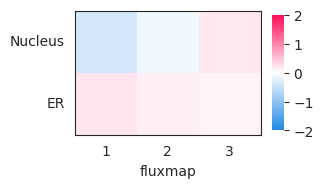

In [22]:
@bt.pl._utils.savefig
def plot_domain_fe(data, fname=None):
    domains = [
        "flux_Nucleus",
        "flux_ER",
    ]

    domain_fe = pd.DataFrame(
        np.stack([data.uns[d] for d in domains], axis=1),
        index=data.uns["cell_raster"].index,
        columns=domains,
    )
    domain_fe.dropna(inplace=True)
    domain_fe = domain_fe.groupby(data.uns["cell_raster"]["fluxmap"]).mean()
    domain_fe.columns = [d.split("flux_")[1] for d in domain_fe.columns]

    # domain_fe = domain_fe.iloc[1:]

    with sns.axes_style("white"):
        fig = plt.figure(figsize=(3, 3))
        ax = sns.heatmap(
            domain_fe.T,
            center=0,
            vmin=-2,
            vmax=2,
            cmap=bt.colors.red2blue,
            square=True,
            cbar_kws=dict(shrink=0.5, aspect=10),
            # figsize=(3, 2),
        )
        ax.spines[:].set_visible(True)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


plot_domain_fe(adata, fname=f"{figdir}/cd8_domain_fe.svg")

In [27]:
domain_palette = {
    "fluxmap3": sns.desaturate("#ef476f", 0.85),
    "fluxmap1": sns.desaturate("#FFD166", 0.85),
}


dx = 0.2

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/cd8_fe_domains.svg


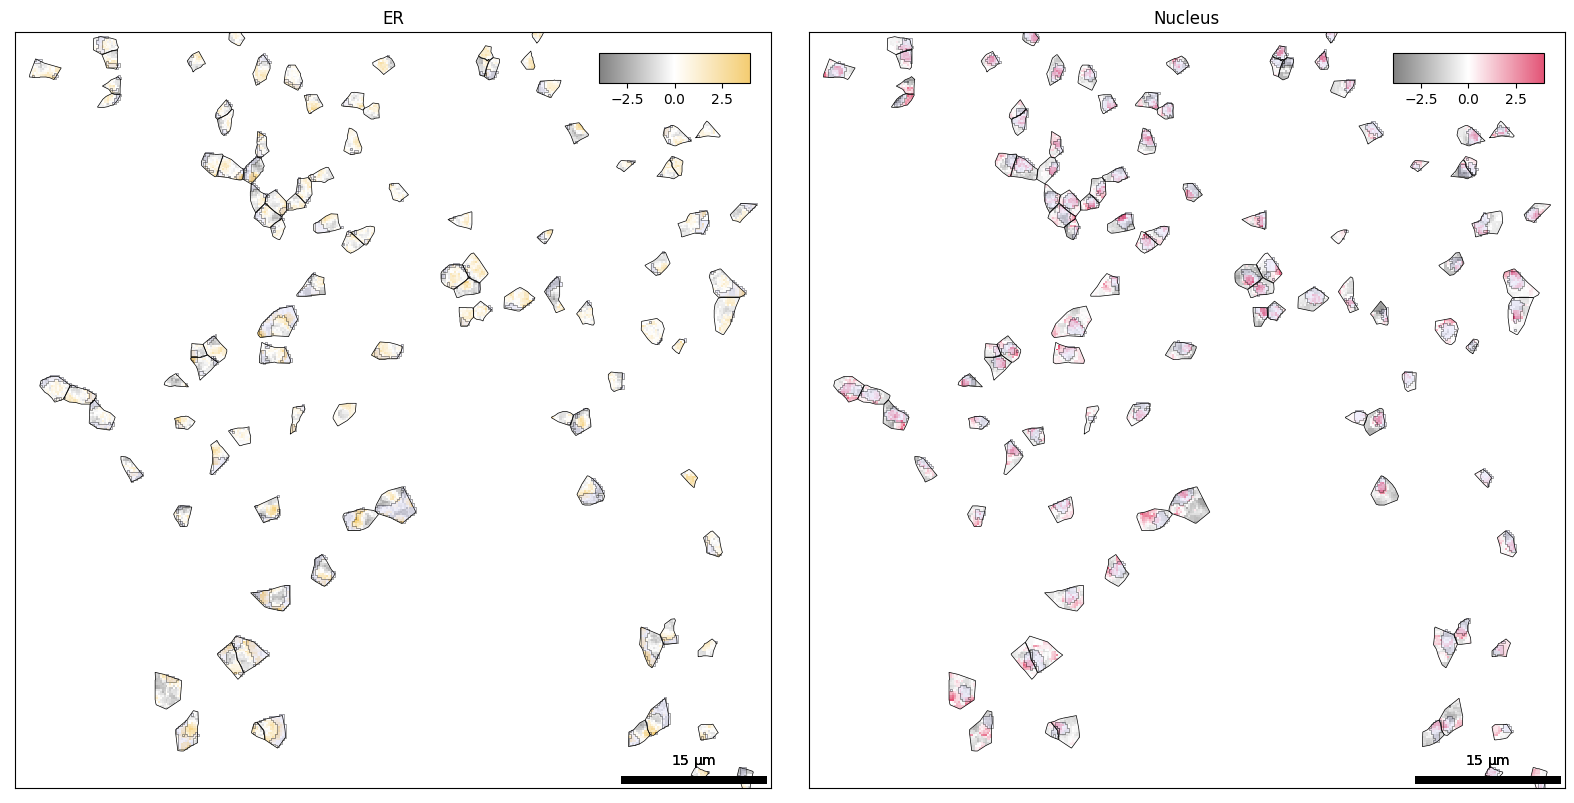

In [29]:
@bt.pl._utils.savefig
def plot_flux_fe(data, fname=None):
    domains = ["flux_Nucleus", "flux_ER"]

    domain_fe = pd.DataFrame(
        np.stack([data.uns[d] for d in domains], axis=1),
        index=data.uns["cell_raster"].index,
        columns=domains,
    )

    domain_fe = domain_fe.groupby(data.uns["cell_raster"]["fluxmap"]).mean()
    domain_fe = domain_fe.iloc[1:, :]
    fluxmap2domain = domain_fe.idxmax(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    for shape, color, ax in zip(
        fluxmap2domain.index[[0, 2]], bt.colors.bento6, axes.flat
    ):
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            "_",
            ["gray", "white", domain_palette[f"fluxmap{shape}"]],  # nuc read er yellow
        )
        domain = fluxmap2domain[shape]
        bt.pl.shapes(
            adata,
            shapes=f"fluxmap{shape}",
            facecolor="blue",
            alpha=0.05,
            lw=0.5,
            ax=ax,
            dx=dx,
        )
        bt.pl.shapes(
            adata,
            shapes=f"fluxmap{shape}",
            alpha=0.5,
            lw=0.5,
            ax=ax,
            dx=dx,
        )
        bt.pl.fe(
            adata,
            domain,
            res=1,
            cmap=cmap,
            ax=ax,
            title=domain.split("_")[1],
            shapes=["cell_shape"],
            square=True,
            vmin=-4,
            vmax=4,
            dx=dx,
        )

    # remove empty axes
    for ax in axes.flat[domain_fe.shape[0] :]:
        ax.remove()
    plt.subplots_adjust(wspace=0.05, hspace=0.1)


plot_flux_fe(adata, fname=f"{figdir}/cd8_fe_domains.svg")